In [ ]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Introduction

The NEO dataset from NASA's JPL, located - https://ssd.jpl.nasa.gov/sbdb_query.cgi, will be evaluated with unsupervised learning. The main objective of this analysis is to use clustering algorithms to find a clustering classification method that produces useful clustering information. One use, in particular, that would be valuable is to utilise clustering classification of for prospecting NEO satellites in space mining operations. The sheer number of potential minable bodies in our solar system is enormous, and we don't even have a significant part of the solar bodies cataloged. The fact that they are so far away and spread out makes prospecting until you find the right asteroid or comet to mine unfeasible. A clustering model can take a sample set of prospecting data and use it to classify clusters and tell the miners where to go prospect and mine without ever having been there before. This project has the potential to save trillions of dollars, or more, that would have otherwise have been spent on blind prospecting. The potential market value of the space mining industry is preposteriously large; just one asteroid that we know of 16-Pshche is estimated to be worth around $700 quadrillion. There are many types of NEO satalites like comets that are composed up of water, CO2, and other compounds and then theres several types of asteroids which can have varrious concentrations of valuable metals. It would be helpful to be able to know what all of these satellites are composed of for mining ooperations but prospecting them all is not fesable and that's what this project aims to correct; at least, virtually.

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

try:
  from umap import UMAP
except ModuleNotFoundError:
  !pip install umap-learn
  from umap import UMAP

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import datasets, metrics
from sklearn.metrics import davies_bouldin_score

from google.colab import drive

%matplotlib inline

In [ ]:
# Mount google drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataset_filepath = "/content/gdrive/My Drive/Colab Notebooks/NEO_Data.csv"

## Data Cleaning and Preparation

In [ ]:
# Import data into DataFrame
df = pd.read_csv(dataset_filepath)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4,5,16,23,24,70) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
# Review dataset features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25391 entries, 0 to 25390
Data columns (total 75 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              25391 non-null  object 
 1   spkid           25391 non-null  int64  
 2   full_name       25391 non-null  object 
 3   pdes            25391 non-null  object 
 4   name            345 non-null    object 
 5   prefix          186 non-null    object 
 6   neo             25391 non-null  object 
 7   pha             25202 non-null  object 
 8   H               25196 non-null  float64
 9   G               13 non-null     float64
 10  M1              129 non-null    float64
 11  M2              49 non-null     float64
 12  K1              129 non-null    float64
 13  K2              49 non-null     float64
 14  PC              31 non-null     float64
 15  diameter        1267 non-null   float64
 16  extent          10 non-null     object 
 17  albedo          1208 non-null  

The features listed above in our data set are abbreviations for astronomical terms in relation to properties of NEO satallite observations and measurements. The definition and meaning of these properties and measurements will not be looked into initially for this proof of concept model analysis. However, model performance and cluster evaluation could benifit from an in-depth study and application of these variables to the training of clustering models. It is useful to be able to look at the variables from a black box perspective and produce a sucessful model.

To look into the features full descriptions, the information is available at the dataset's source - https://ssd.jpl.nasa.gov/sbdb_query.cgi

In [ ]:
# Inspect feature content
pd.set_option("max_columns", 80)
df.head(10)

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,G,M1,M2,K1,K2,PC,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,H_sigma,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,producer,data_arc,first_obs,last_obs,n_obs_used,n_del_obs_used,n_dop_obs_used,condition_code,rms,two_body,A1,A2,A3,DT
0,a0000433,2000433,433 Eros (A898 PA),433,Eros,NaN,Y,N,10.40,0.46,NaN,NaN,NaN,NaN,NaN,16.840,34.4x11.2x11.2,0.250,5.27000,0.000446,0.921,0.531,NaN,S,S,NaN,0.060,JPL 658,2459000.5,59000.0,20200531.0,J2000,0.222951,1.458046,1.132973,10.830541,304.299326,178.882296,271.071733,1.783119,0.559819,2.459159e+06,2.020111e+07,643.065402,1.760617,0.148623,57.839613,3.28650,4.582,9.649700e-09,2.137400e-10,1.406300e-08,0.000001,0.000004,0.000004,0.000001,2.613900e-10,1.231000e-10,0.000003,1.414000e-07,AMO,Giorgini,46330.0,1893-10-29,2020-09-03,8767,4.0,2.0,0.0,0.28397,NaN,NaN,NaN,NaN,NaN
1,a0000719,2000719,719 Albert (A911 TB),719,Albert,NaN,Y,N,15.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.80100,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,JPL 216,2459000.5,59000.0,20200531.0,J2000,0.546558,2.638602,1.196452,11.567485,183.866947,156.176341,140.273422,4.080752,0.229955,2.458390e+06,2.018093e+07,1565.522355,4.286167,0.203482,79.189090,1.41794,3.140,2.177900e-08,2.530500e-09,5.810300e-08,0.000003,0.000016,0.000017,0.000003,3.913500e-09,3.308000e-10,0.000010,2.252000e-06,AMO,Otto Matic,39939.0,1911-10-04,2021-02-07,1882,NaN,NaN,0.0,0.39319,NaN,NaN,NaN,NaN,NaN
2,a0000887,2000887,887 Alinda (A918 AA),887,Alinda,NaN,Y,N,13.84,-0.12,NaN,NaN,NaN,NaN,NaN,4.200,NaN,0.310,73.97000,NaN,0.832,0.436,NaN,NaN,S,NaN,NaN,JPL 360,2459200.5,59200.0,20201217.0,J2000,0.570422,2.473534,1.062575,9.393848,110.433737,350.512499,345.243769,3.884493,0.253354,2.459259e+06,2.021021e+07,1420.938218,3.890317,0.081753,31.815854,1.31479,3.221,4.073700e-08,4.761300e-09,1.021800e-07,0.000003,0.000024,0.000025,0.000007,7.477300e-09,7.315200e-10,0.000027,4.102700e-06,AMO,Otto Matic,37643.0,1918-02-03,2021-02-25,2132,NaN,NaN,0.0,0.42233,NaN,NaN,NaN,NaN,NaN
3,a0001036,2001036,1036 Ganymed (A924 UB),1036,Ganymed,NaN,Y,N,9.30,0.30,NaN,NaN,NaN,NaN,NaN,37.675,NaN,0.238,10.29700,NaN,0.842,0.417,NaN,S,S,NaN,0.399,JPL 886,2459200.5,59200.0,20201217.0,J2000,0.533095,2.665194,1.244393,26.676147,215.544195,132.378555,50.117962,4.085995,0.226522,2.458979e+06,2.020051e+07,1589.247561,4.351123,0.343891,133.832060,1.95302,3.034,2.263300e-08,2.047200e-09,6.030500e-08,0.000004,0.000007,0.000007,0.000002,3.138600e-09,2.610000e-10,0.000010,1.831100e-06,AMO,Otto Matic,35191.0,1924-10-23,2021-02-27,6807,0.0,1.0,0.0,0.37325,NaN,NaN,NaN,NaN,NaN
4,a0001221,2001221,1221 Amor (1932 EA1),1221,Amor,NaN,Y,N,17.39,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JPL 104,2459000.5,59000.0,20200531.0,J2000,0.435285,1.919498,1.083969,11.876540,171.327012,26.694788,38.522411,2.755027,0.370615,2.458897e+06,2.020022e+07,971.359459,2.659437,0.107450,41.816316,2.21364,3.781,3.448700e-08,9.463600e-10,6.656900e-08,0.000005,0.000023,0.000024,0.000008,1.358300e-09,2.740800e-10,0.000022,7.183600e-07,AMO,Otto Matic,32328.0,1932-03-12,2020-09-14,552,NaN,NaN,0.0,0.45839,NaN,NaN,NaN,NaN,NaN
5,a0001566,2001566,1566 Icarus (1949 MA),1566,Icarus,NaN,Y,Y,16.34,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,0.510,2.27260,NaN,0.774,0.520,NaN,NaN,NaN,NaN,NaN,JPL 119,2459000.5,59000.0,20200531.0,J2000,0.827021,1.078169,0.186500,22.822106,87.997546,31.393339,192.083179,1.969838,0.880387,2.459191e+06,2.020121e+07,408.910857,1.119537,0.034245,13.327010,3.21481,5.298,3.106600e-08,2.793300e-09,3.347700e-08,0.000010,0.000004,0.000006,0.000006,5.103400e-09,3.421300e-09,0.000008,1.589100e-06,APO,Otto Matic,26002.0,1949-07-01,2020-09-08,1052,10.0,13.0,0.0,0.34334,NaN,NaN,-3.052891e-15,NaN,NaN
6,a0001580,2001580,1580 Betulia (1950 KA),1580,Betulia,NaN,Y,N,14.70,0.00,NaN,NaN,NaN,NaN

Below I'm dropping several features for various reasons. I drop many beacause they are sparsly populated and contaon mostly NaN data. Then I drop the catagorical data for a few reasons. One reason is because I'm trying to train a classifier and do not want to include bias in my results. Working with the catagorical and numerical data presents more challenges and limits my modeling options. Lastly, I'm trying to keep this initial investigation simple and basic to serve as a proof of concept. 

In [ ]:
# Drop features not useful for analysis
df = df.drop(
    [
        "class",
        "pha",
        "id",
        "spkid",
        "full_name",
        "neo",
        "pdes",
        "name",
        "prefix",
        "G",
        "M1",
        "M2",
        "K1",
        "K2",
        "PC",
        "extent",
        "GM",
        "IR",
        "H_sigma",
        "diameter_sigma",
        "orbit_id",
        "epoch",
        "epoch_mjd",
        "epoch_cal",
        "equinox",
        "tp",
        "tp_cal",
        "diameter",
        "albedo",
        "rot_per",
        "BV",
        "UB",
        "spec_B",
        "spec_T",
        "n_del_obs_used",
        "n_dop_obs_used",
        "two_body",
        "A1",
        "A2",
        "A3",
        "DT",
        "producer",
        "first_obs",
        "last_obs",
        "n_obs_used",
    ],
    axis=1,
)

In [ ]:
# Review Dataframe again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25391 entries, 0 to 25390
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   H               25196 non-null  float64
 1   e               25391 non-null  float64
 2   a               25391 non-null  float64
 3   q               25391 non-null  float64
 4   i               25391 non-null  float64
 5   om              25391 non-null  float64
 6   w               25391 non-null  float64
 7   ma              25391 non-null  float64
 8   ad              25391 non-null  float64
 9   n               25391 non-null  float64
 10  per             25391 non-null  float64
 11  per_y           25391 non-null  float64
 12  moid            25382 non-null  float64
 13  moid_ld         25382 non-null  float64
 14  moid_jup        25290 non-null  float64
 15  t_jup           25391 non-null  float64
 16  sigma_e         25380 non-null  float64
 17  sigma_a         25380 non-null 

In [ ]:
df.head(5)

,H,e,a,q,i,om,w,ma,ad,n,per,per_y,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,data_arc,condition_code,rms
0,10.40,0.222951,1.458046,1.132973,10.830541,304.299326,178.882296,271.071733,1.783119,0.559819,643.065402,1.760617,0.148623,57.839613,3.28650,4.582,9.649700e-09,2.137400e-10,1.406300e-08,0.000001,0.000004,0.000004,0.000001,2.613900e-10,1.231000e-10,0.000003,1.414000e-07,46330.0,0.0,0.28397
1,15.51,0.546558,2.638602,1.196452,11.567485,183.866947,156.176341,140.273422,4.080752,0.229955,1565.522355,4.286167,0.203482,79.189090,1.41794,3.140,2.177900e-08,2.530500e-09,5.810300e-08,0.000003,0.000016,0.000017,0.000003,3.913500e-09,3.308000e-10,0.000010,2.252000e-06,39939.0,0.0,0.39319
2,13.84,0.570422,2.473534,1.062575,9.393848,110.433737,350.512499,345.243769,3.884493,0.253354,1420.938218,3.890317,0.081753,31.815854,1.31479,3.221,4.073700e-08,4.761300e-09,1.021800e-07,0.000003,0.000024,0.000025,0.000007,7.477300e-09,7.315200e-10,0.000027,4.102700e-06,37643.0,0.0,0.42233
3,9.30,0.533095,2.665194,1.244393,26.676147,215.544195,132.378555,50.117962,4.085995,0.226522,1589.247561,4.351123,0.343891,133.832060,1.95302,3.034,2.263300e-08,2.047200e-09,6.030500e-08,0.000004,0.000007,0.000007,0.000002,3.138600e-09,2.610000e-10,0.000010,1.831100e-06,35191.0,0.0,0.37325
4,17.39,0.435285,1.919498,1.083969,11.876540,171.327012,26.694788,38.522411,2.755027,0.370615,971.359459,2.659437,0.107450,41.816316,2.21364,3.781,3.448700e-08,9.463600e-10,6.656900e-08,0.000005,0.000023,0.000024,0.000008,1.358300e-09,2.740800e-10,0.000022,7.183600e-07,32328.0,0.0,0.45839


In [ ]:
df.isna().mean()

H                 0.007680
e                 0.000000
a                 0.000000
q                 0.000000
i                 0.000000
om                0.000000
w                 0.000000
ma                0.000000
ad                0.000000
n                 0.000000
per               0.000000
per_y             0.000000
moid              0.000354
moid_ld           0.000354
moid_jup          0.003978
t_jup             0.000000
sigma_e           0.000433
sigma_a           0.000433
sigma_q           0.000433
sigma_i           0.000433
sigma_om          0.000433
sigma_w           0.000433
sigma_ma          0.000433
sigma_ad          0.000433
sigma_n           0.000433
sigma_tp          0.000433
sigma_per         0.000433
data_arc          0.008980
condition_code    0.000433
rms               0.000315
dtype: float64

In [ ]:
# Drop small number of nulls
df = df.dropna()

In [ ]:
df.shape

(24971, 30)

Removing rows with null values only eliminated 420 observations out of 25,391, or just 1.65% of the data. For this initial investigation, this is considered an acceptable loss of data and should not effect the results in a measurable way. In future development, methods of handling the null values will be implimented to maximize the integrity of the data.

In [ ]:
# Check out the overall statistics
df.describe()

,H,e,a,q,i,om,w,ma,ad,n,per,per_y,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,data_arc,condition_code,rms
count,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,2.497100e+04,24971.000000,2.497100e+04,24971.000000,24971.000000,24971.000000,2.497100e+04,2.497100e+04,2.497100e+04,2.497100e+04,2.497100e+04,2.497100e+04,2.497100e+04,2.497100e+04,2.497100e+04,2.497100e+04,2.497100e+04,24971.000000,24971.000000,24971.000000
mean,22.963339,0.442264,1.778201,0.915085,12.464808,173.415186,182.035650,175.861240,2.641317,0.520098,9.926342e+02,2.717684,9.266544e-02,36.062609,2.690652,4.252798,3.732571e-03,2.159542e-02,1.877974e-03,8.753041e-02,1.146003e-01,2.958771e-01,6.766854e-01,3.577020e-02,3.955681e-03,1.156975e+00,5.158999e+01,1401.900004,5.015338,0.480894
std,2.943887,0.177074,2.329314,0.231736,11.087191,103.647876,104.377440,122.554621,4.641281,0.281345,1.534744e+04,42.018990,1.017516e-01,39.598683,0.966270,1.069505,8.455745e-02,7.550461e-01,4.287180e-02,1.970661e+00,3.056392e+00,6.037218e+00,1.336362e+01,1.376194e+00,9.488704e-02,3.488909e+01,5.536660e+03,3061.951388,3.242249,0.124875
min,9.300000,0.002846,0.555425,0.070511,0.013518,0.025992,0.007924,0.005210,0.653740,0.000149,1.511945e+02,0.413948,4.544120e-07,0.000177,0.000778,-1.205000,7.690300e-10,4.026100e-11,9.401900e-10,1.901100e-07,2.823900e-07,5.732200e-07,2.103800e-07,4.846400e-11,2.856800e-11,2.687500e-07,2.335000e-08,1.000000,0.000000,0.037189
25%,20.700000,0.311336,1.306606,0.786294,4.555753,83.345639,92.210163,53.444982,1.699990,0.303220,5.455262e+02,1.493569,1.545760e-02,6.015634,1.945610,3.421000,5.032150e-07,1.337250e-07,5.332700e-07,3.649900e-05,5.310150e-05,1.137100e-04,1.692800e-04,1.969050e-07,5.193750e-08,2.312800e-04,9.797250e-05,7.000000,1.000000,0.396390
50%,23.200000,0.455850,1.709496,0.964989,8.776845,172.703429,183.863172,171.877177,2.471957,0.440963,8.163957e+02,2.235170,5.205970e-02,20.260073,2.831520,4.012000,1.441300e-04,2.867500e-04,2.246000e-05,1.771400e-03,5.007700e-04,1.641500e-03,4.382500e-02,3.906100e-04,1.472200e-04,1.744100e-02,1.938300e-01,29.000000,6.000000,0.471480
75%,25.200000,0.568216,2.194306,1.068242,17.659230,256.062893,271.996770,298.338697,3.391781,0.659913,1.187256e+03,3.250529,1.413785e-01,55.020271,3.529210,4.878000,8.796700e-04,2.645750e-03,1.755350e-04,1.390050e-02,3.668100e-03,1.221250e-02,2.245600e-01,3.805750e-03,1.034850e-03,2.150150e-01,1.895300e+00,1378.000000,8.000000,0.554080
max,32.950000,0.996476,352.628376,1.299988,165.540886,359.977966,359.982032,359.998040,704.014132,2.381039,2.418657e+06,6621.922401,7.077220e-01,275.424171,4.621490,9.987000,8.411300e+00,8.466800e+01,3.433200e+00,1.489500e+02,2.751700e+02,5.370100e+02,1.215800e+03,1.690400e+02,8.671700e+00,4.949200e+03,8.711000e+05,46330.000000,9.000000,1.752000


In [ ]:
# Use for rapid model development
# df = df.sample(10000, random_state=42)
# df.shape

## Data Standardization

In [ ]:
# Scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
scaled = pd.DataFrame(scaled, columns=df.columns, index=df.index)
scaled.head()

,H,e,a,q,i,om,w,ma,ad,n,per,per_y,moid,moid_ld,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,data_arc,condition_code,rms
0,-4.267688,-1.238561,-0.137449,0.940257,-0.147404,1.262802,-0.030212,0.776898,-0.184909,0.141185,-0.022777,-0.022777,0.549954,0.549954,0.616660,0.307814,-0.044143,-0.028602,-0.043805,-0.044417,-0.037495,-0.049009,-0.050637,-0.025993,-0.041689,-0.033162,-0.009318,14.673322,-1.546901,-1.577003
1,-2.531853,0.588999,0.369387,1.214191,-0.080935,0.100841,-0.247753,-0.290389,0.310144,-1.031289,0.037329,0.037329,1.089111,1.089111,-1.317166,-1.040501,-0.044143,-0.028602,-0.043804,-0.044416,-0.037491,-0.049007,-0.050637,-0.025993,-0.041689,-0.033162,-0.009318,12.586049,-1.546901,-0.702348
2,-3.099141,0.723770,0.298520,0.636466,-0.276988,-0.607660,1.614144,1.382126,0.267857,-0.948121,0.027908,0.027908,-0.107247,-0.107247,-1.423919,-0.964763,-0.044143,-0.028602,-0.043803,-0.044416,-0.037488,-0.049006,-0.050637,-0.025993,-0.041689,-0.033161,-0.009318,11.836186,-1.546901,-0.468989
3,-4.641351,0.512964,0.380803,1.421071,1.281806,0.406471,-0.475755,-1.026039,0.311273,-1.043491,0.038875,0.038875,2.469057,2.469057,-0.763396,-1.139614,-0.044143,-0.028602,-0.043804,-0.044416,-0.037494,-0.049009,-0.050637,-0.025993,-0.041689,-0.033162,-0.009318,11.035373,-1.546901,-0.862031
4,-1.893228,-0.039414,0.060662,0.728792,-0.053059,-0.020147,-1.488291,-1.120656,0.024500,-0.531326,-0.001386,-0.001386,0.145303,0.145303,-0.493673,-0.441146,-0.044143,-0.028602,-0.043804,-0.044415,-0.037489,-0.049006,-0.050637,-0.025993,-0.041689,-0.033162,-0.009318,10.100330,-1.546901,-0.180214


## Dimension Reduction

### PCA

In [ ]:
# Dimension Reduction - Principal Component Analysis
pca = PCA(n_components=2)

In [ ]:
pca_components = pca.fit_transform(scaled)

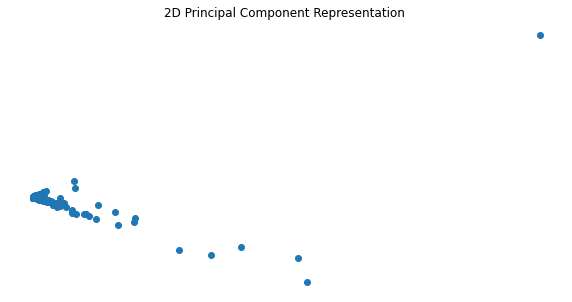

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.title("2D Principal Component Representation ")
plt.axis("off")
plt.show()

It's difficult to find much cluster meaning in this 2D representation. PCA is not the best coice for visualization but it will still be very helpful with the clustering analysis. A furthur investigation recommendation is to try more visualization with t-SNE or UMAP. Even so, we can see there is some interpretable structure in the data points. This provides an indication that even by reducing all of the features down to two dimensions PCA is retaining enough data to identify clusters.   

### UMAP

In [ ]:
umap = UMAP(n_neighbors=100, n_components=2)
X_umap = umap.fit_transform(scaled)

X_umap = pd.DataFrame(X_umap, index=df.index, columns=['umap1', 'umap2'])
#X_umap['Pos'] = df['Pos']
X_umap = X_umap.reset_index()
X_umap.head()

px.scatter(X_umap, 'umap1','umap2') # , color='Pos'

UMAP is clearly superior at creating a 2D plot that allows you to see clear groupings and patterns in the data; at least compared to PCA in this case. It's too bad that's theres no ground truth data to test so preliminnary shading on. However, UMAP should should show us a better picture after the clustering.

## Select Principal Components

Next, I evaluate the performance of selecting different numbers of principal components so I can utilise dimension reduction most effectivly for the upcoming clustering.

In [ ]:
pca = PCA()
pca.fit(scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Variance explained by each component
pca.explained_variance_

array([7.17094391e+00, 5.33529219e+00, 3.99273189e+00, 2.87341228e+00,
       1.72094651e+00, 1.12308899e+00, 1.07469932e+00, 1.02752021e+00,
       9.56445427e-01, 9.10535810e-01, 8.91430665e-01, 7.26643102e-01,
       5.85142935e-01, 3.35445724e-01, 3.20522637e-01, 2.08480456e-01,
       1.93286549e-01, 1.54674176e-01, 1.32384979e-01, 1.17673108e-01,
       6.59282900e-02, 3.94338138e-02, 2.24425847e-02, 2.00913491e-02,
       1.40199772e-03, 4.06327720e-04, 1.96195520e-04, 1.41421933e-30,
       1.08908060e-31, 1.42552356e-32])

In [ ]:
# Variance explained by each component (as a percentage)
pca.explained_variance_ratio_

array([2.39021891e-01, 1.77835951e-01, 1.33085733e-01, 9.57765737e-02,
       5.73625864e-02, 3.74348006e-02, 3.58218762e-02, 3.42493020e-02,
       3.18802375e-02, 3.03499782e-02, 2.97131655e-02, 2.42204668e-02,
       1.95039834e-02, 1.11810763e-02, 1.06836600e-02, 6.94907024e-03,
       6.44262695e-03, 5.15559939e-03, 4.41265593e-03, 3.92227985e-03,
       2.19752166e-03, 1.31440782e-03, 7.48056199e-04, 6.69684817e-04,
       4.67313858e-05, 1.35437149e-05, 6.53958875e-06, 4.71387564e-32,
       3.63012328e-33, 4.75155493e-34])

In [ ]:
# Cumulative explained variance
np.cumsum(pca.explained_variance_ratio_)

array([0.23902189, 0.41685784, 0.54994358, 0.64572015, 0.70308274,
       0.74051754, 0.77633941, 0.81058871, 0.84246895, 0.87281893,
       0.9025321 , 0.92675256, 0.94625655, 0.95743762, 0.96812128,
       0.97507035, 0.98151298, 0.98666858, 0.99108123, 0.99500351,
       0.99720104, 0.99851544, 0.9992635 , 0.99993319, 0.99997992,
       0.99999346, 1.        , 1.        , 1.        , 1.        ])

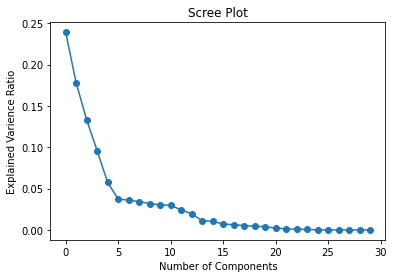

In [ ]:
# Scree plot
plt.plot(pca.explained_variance_ratio_, "-o")
plt.title("Scree Plot")
plt.xlabel("Number of Components")
plt.ylabel("Explained Varience Ratio")
plt.show()

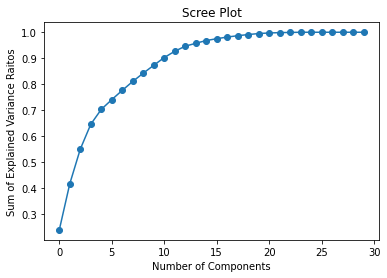

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), "-o")
plt.title("Scree Plot")
plt.xlabel("Number of Components")
plt.ylabel("Sum of Explained Variance Raitos")
plt.show()

It looks like using first 10 principal components will account for the majority of the variance in the data.

In [ ]:
pca = PCA(n_components=10)
components = pca.fit_transform(scaled)

components = pd.DataFrame(
    components,
    columns=["pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10"],
    index=scaled.index,
)
components.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-0.132505,0.612524,-4.410440,7.161782,5.289144,4.278497,4.019761,3.425324,-3.524152,0.044943
1,0.488963,1.451979,-5.826169,4.234614,4.453119,2.987397,4.006555,2.098601,-2.723166,0.114261
2,0.345039,1.268784,-4.916424,3.480906,5.476479,2.680155,4.255070,1.069852,-3.467782,0.220752
3,0.700289,1.658717,-7.271817,5.733632,3.415459,1.680472,2.674488,2.275709,-1.982818,0.120503
4,0.085055,0.786838,-3.628189,3.638850,3.950448,2.918595,3.489597,1.663078,-1.798219,0.047087


## DBSCAN Clustering

In [ ]:
# Perform initial clustering
clusters = DBSCAN(eps=0.8, min_samples=19, metric="euclidean", n_jobs=-1)
clusters.fit(components)

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=19, n_jobs=-1, p=None)

In [ ]:
# Assign labels to the dataframe
df["label"] = clusters.labels_
#df["label"] = "Cluster: " + df["label"].astype(str)

In [ ]:
dbscan_clusters = df
dbscan_clusters["label"].value_counts()

-1    22447
 0     2176
 1      147
 2      133
 3       39
 4       16
 5       13
Name: label, dtype: int64

In [ ]:
# Silhouette Score
labels = clusters.fit_predict(components)
metrics.silhouette_score(components, labels, metric="euclidean")

-0.2570466547248683

In [ ]:
# Davies Bouldin Score
davies_bouldin_score(components, labels)

1.9081883187766677

In [ ]:
umap = UMAP(n_neighbors=100, n_components=2)
X_umap = umap.fit_transform(dbscan_clusters)

X_umap = pd.DataFrame(X_umap, index=df.index, columns=['umap1', 'umap2'])
X_umap['label'] = df['label']
X_umap = X_umap.reset_index()
X_umap.head()

px.scatter(X_umap, 'umap1','umap2', color='label')

It's clear that ther are better defined groups. However the unassigned observations are overshadowing everything, so let's try again and clear the -1 labels off the slate.

In [ ]:
dbscan_clusters_cleaned = dbscan_clusters[dbscan_clusters["label"] != -1]

In [ ]:
df_cleaned = df[df["label"] != -1]

In [ ]:
umap = UMAP(n_neighbors=100, n_components=2)
X_umap = umap.fit_transform(dbscan_clusters_cleaned)

X_umap = pd.DataFrame(X_umap, index=df_cleaned.index, columns=['umap1', 'umap2'])
X_umap['label'] = df['label']
X_umap = X_umap.reset_index()
X_umap.head()

px.scatter(X_umap, 'umap1','umap2', color='label')

Now the data groupings are much easier to see. It will be hard to tell what these groupings mean. It's good to have this tool to view the data moving forwards and it can be used to help optimize this analysis and assign cluster information when prospecting data becomes available. It will also be very difficult to establish a very meaningful understanding of what exactly differentiates these clusters due to the PCA dimension reduction that was performed earlier. 

However that does not say much to the benifit of PCA nd dimensionality reduction. It it a great tool in the process of creating an unsupervised learning clustering analysis. The PCA helps to capture feature relationships that were not engineered and can form complex meaningful relationships that help us understand the nature of our data and the cluster we find. The clustering algorithms allow us to percieve the clustering relationships in different but no less meaningful ways that can have their own insights and use cases associated with them.

Since we do not have a ground truth to compare clusters to at the moment, I will use the Silhouette Score and the Davies Bouldin Score for evaluating the clustering. The parameters for `eps` and `min_samples` will be optimised below.

## DBSCAN Cluster Evaluation  

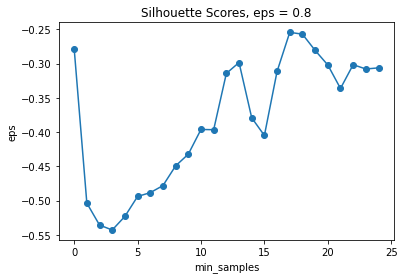

<IPython.core.display.Javascript object>

In [ ]:
epsilon = 0.8
max_samples = 25
silhouettes = []
for samples in range(1, max_samples + 1):
    labels = DBSCAN(
        eps=epsilon, min_samples=samples, metric="euclidean", n_jobs=-1
    ).fit_predict(components)
    silhouette = metrics.silhouette_score(components, labels, metric="euclidean")
    silhouettes.append(silhouette)
plt.title("Silhouette Scores, eps = 0.8")
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.plot(silhouettes, "-o")

In [ ]:
print(silhouettes)

[-0.2781448237914977, -0.503502760364474, -0.5354585896010304, -0.542694062423307, -0.5228178747165709, -0.49375973754971236, -0.48818675123279276, -0.4779169412693037, -0.44915041170440184, -0.43206379533320455, -0.3960304122276044, -0.39639921569018666, -0.3142908903483431, -0.29838875673624354, -0.37901917393455165, -0.4048345578615378, -0.31133006202204466, -0.2543621661615011, -0.2570466429825432, -0.2807080054850371, -0.30196882882858134, -0.3362280587537896, -0.30150818142391755, -0.3078552816544328, -0.30616302010423185]


<IPython.core.display.Javascript object>

### Test records of high performing models
* eps = 0.5, min_samp = 5, sil = -0.4452
* eps = 0.5, min_samp = 6, sil = -0.3547
* eps = 0.5, min_samp = 7, sil = -0.2983
* eps = 0.6, min_samp = 7, sil = -0.4447
* eps = 0.6, min_samp = 8, sil = -0.3954
* eps = 0.6, min_samp = 9, sil = -0.3734
* eps = 0.6, min_samp = 10, sil = -0.3332
* eps = 0.6, min_samp = 11, sil = -0.2269
* eps = 0.7, min_samp = 15, sil = -0.3660
* eps = 0.7, min_samp = 22, sil = -0.2893
* eps = 0.7, min_samp = 23, sil = -0.1883
* eps = 0.8, min_step = 14, sil = -0.2984
* eps = 0.8, min_step = 18, sil = -0.2544
* eps = 0.8, min_step = 19, sil = -0.2570
* eps = 0.8, min_step = 23, sil = -0.3015
* eps = 1, min_samp = 25, sil = 0.0618
* eps = 1.1, min_samp = 22, sil = 0.1229
* eps = 1.2, min_samp = 19, sil = 0.1716
* eps = 1.3, min_samp = 12, sil = 0.2536
* eps = 1.4, min_samp = 10, sil = 0.3241
* eps = 1.5, min_samp = 9, sil = 0.4059
* eps = 1.6, min_samp = 7, sil = 0.4059
* eps = 1.7, min_samp = 6, sil = 0.5400
* eps = 1.8, min_samp = 6, sil = 0.5888
* eps = 1.9, min_samp = 6, sil = 0.6336
* eps = 2.0, min_samp = 6, sil = 0.6653
* eps = 2.1, min_samp = 7, sil = 0.6952
* eps = 2.2, min_samp = 4, sil = 0.7424
* eps = 2.3, min_samp = 4, sil = 0.7627
* eps = 2.4, min_samp = 4, sil = 0.7960
* eps = 2.5, min_samp = 4, sil = 0.8074
* eps = 3.0, min_samp = 3, sil = 0.8074
* eps = 3.5, min_samp = 4, sil = 0.8074


Now that the parameters have been optimised, as far as the silhouette score is concerned, it's time to take a look at the clusters produced by this set of parameters.

In [ ]:
params = [
    [0.8, 14],
    [0.8, 18],
    [0.8, 19],
    [0.8, 20],
    [0.8, 21],
    [0.8, 23],
]


""" Code for exploring clustering results using optimal parameters
    [0.5, 5],
    [0.5, 6],
    [0.5, 7],
    [0.6, 7],
    [0.6, 8],
    [0.6, 9],
    [0.6, 10],
    [0.6, 11],
    [0.7, 15],
    [0.7, 16],
    [0.7, 17],
    [0.7, 18],
    [0.7, 19],
    [0.7, 20],
    [0.7, 21],
    [0.7, 22],
    [0.7, 23],
    [0.8, 24],
    [0.8, 25],
    [0.8, 26],
    [0.8, 27],
    [0.8, 28],
    [0.8, 29],
    [0.8, 30],
    [1, 25],
    [1.1, 22],
    [1.2, 19],
    [1.3, 12],
    [1.4, 10],
    [1.5, 9],
    [1.6, 7],
    [1.7, 6],
    [1.8, 6],
    [1.9, 6],
    [2, 6],
    [2.1, 7],
    [2.2, 4],
    [2.3, 4],
    [2.4, 4],
    [2.5, 4],
"""

' Code for exploring clustering results using optimal parameters\n    [0.5, 5],\n    [0.5, 6],\n    [0.5, 7],\n    [0.6, 7],\n    [0.6, 8],\n    [0.6, 9],\n    [0.6, 10],\n    [0.6, 11],\n    [0.7, 15],\n    [0.7, 16],\n    [0.7, 17],\n    [0.7, 18],\n    [0.7, 19],\n    [0.7, 20],\n    [0.7, 21],\n    [0.7, 22],\n    [0.7, 23],\n    [0.8, 24],\n    [0.8, 25],\n    [0.8, 26],\n    [0.8, 27],\n    [0.8, 28],\n    [0.8, 29],\n    [0.8, 30],\n    [1, 25],\n    [1.1, 22],\n    [1.2, 19],\n    [1.3, 12],\n    [1.4, 10],\n    [1.5, 9],\n    [1.6, 7],\n    [1.7, 6],\n    [1.8, 6],\n    [1.9, 6],\n    [2, 6],\n    [2.1, 7],\n    [2.2, 4],\n    [2.3, 4],\n    [2.4, 4],\n    [2.5, 4],\n'

In [ ]:
for param in params:
    clusters = DBSCAN(eps=param[0], min_samples=param[1], metric="euclidean", n_jobs=-1)
    clusters.fit(components)
    df["label"] = clusters.labels_
    df["label"] = "Cluster: " + df["label"].astype(str)
    dbscan_clusters = df[df["label"] != "Cluster: -1"]

    print("\n")
    print("Eps: " + str(param[0]) + ", min_samples: " + str(param[1]))
    print(dbscan_clusters["label"].value_counts())



Eps: 0.8, min_samples: 14
Cluster: 1    4046
Cluster: 0      27
Cluster: 7      22
Cluster: 6      21
Cluster: 5      20
Cluster: 2      13
Cluster: 3      13
Cluster: 4       9
Cluster: 8       6
Name: label, dtype: int64


KeyboardInterrupt: ignored

In nearly every case, the models with positive silhouette scores could only identify one cluster. Therefore, the models with the best negative silhouette scores should wil evaluated to select the best performing model.

After reviewing the silhouette scores and clustering groups of several variations of combinations of eps and min_sample combinations, I find that using `eps = 0.8` and `min_sample = 19` to be one of the best classification models to be produced, resulting with `silhoette_score = -0.2570`, which is not terrible. It's a model with one of the closest scores to 0. It classifies 2524 satellites into 6 groups. True, 10% percent population classification seems poor, it can be improved, however it should still be sufficient to be useful for prospecting and mining, even at this stage of development.

## K-means Clustering

In [ ]:
# Fit kmeans
k = 6
clusters = KMeans(n_clusters=k, verbose=0, random_state=42)
clusters.fit(components)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
df["label"] = clusters.labels_
df["label"] = "Cluster: " + df["label"].astype(str)

kmeans_clusters = df[df["label"] != "Cluster: -1"]
kmeans_clusters["label"].value_counts()

Cluster: 0    9582
Cluster: 3    8827
Cluster: 4    6533
Cluster: 5      23
Cluster: 2       5
Cluster: 1       1
Name: label, dtype: int64

## K-means Clustering Evaluation

In [ ]:
# Silhouette Score
labels = clusters.predict(components)
metrics.silhouette_score(components, labels, metric="euclidean")

0.20249082658392764

In [ ]:
# Davies Bouldin Score
davies_bouldin_score(components, labels)

1.0415781530991532

Using `k = 6`, like the best DBSCAN model, the K-means algorithm divides all of the NEO satellites into 3 significant clusters and 3 minor outlier clusters. Also the Silhouette and Davies Bouldin scores are much better than thoes for the best DBSCAN model. Checking different number of clusters with K-means lets us find a best fit. Looking at cluster numbers less than and more than the clusters found by DBSCAN shows us that K-means also has higher performance with 6 clusters than models with less or more clusters.
* Using 4 clusters: `silhouette_score = 0.1927` and `davis_bouldin_score = 1.0323`
* Using 5 clusters: `silhouette_score = 0.2013` and `davis_bouldin_score = 1.0650`
* Using 6 clusters: `silhouette_score = 0.2025` and `davis_bouldin_score = 1.0415`
* Using 7 clusters: `silhouette_score = 0.2006` and `davis_bouldin_score = 1.1433`
* Using 8 clusters: `silhouette_score = 0.1578` and `davis_bouldin_score = 1.3274`

## In Conclusion

DBSCAN had trouble producing a useful model with a positive silhouette score; however, models resulting with negative silhouette scores greater than -1 also produce meaningful cluster results. The best model clustered 10% of the satalites using `eps = 0.8` and `min_samples = 19`, which resulted with `silhoette_score = -0.2570` and `davies_bouldin_score = 1.9081`. There was leeway in choosing the best cluster result in terms of the number of clusters, total amount classified, and distribution of classifications. I chose a model that classified a relativly large number of satellites and had a 6 cluster distribution. The number of clusters is a somewhat arbitrary but it makes sense for a number of classes that a mining company would be concerned with. Furthur research into asteroid mining itself should produce useful information, such as the best number of clusters for this type of use case. 

K-means was able to produce the best model, in terms of the post clustering evaluation via the Silhouette and Daies Bouldin Scores. The best model clustered 100% of the satalites into 6 groups using `k = 6` for the number of clusters. The clustering evaluation metrics show that `k = 6` produces the best performing model, agreeing with the DBSCAN model results. However, K-means outperformed DBSCAN by making more classifications and much better clustering evaluation metrics, which were `silhoette_score = 0.2025` and `davies_bouldin_score = 1.0415`.

At this time in the analysis, it would be recommended to choose the K-means model over the DBSCAN model. Also, PCA is very useful for dimension reduction of the dataset but not very useful for 2D representations compared to UMAP. UMAP has much mor potential at interpreting this dataset than PCA. The true precision and reliabilty of either model is unavailable at this time due to insufficient data available. Although this initial investigation only made use of the continuous variables and blackbox methodology towards the fatures, both clustering models DBSCAN and K-means, along with PCA and UMAP, produced interesting and potentially useful results. Additionally, utilizing this investigation as a baseline, it is easier to understand a path forwards to making a much more precise and reliable clustering model for the classification of satellites for the purpose of prospecting and mining. It will be extreamly valuable to this classification utility to have access to any prospecting data that may become available. 

### Recommendations for Improvements

* Impliment method for automatically determining the optimal value for the hyperparameters being used.
* Obtain asteroid prospecting data so that we have existing labels or a "ground truth" to tune the performance of the model.
* Utilize feature definitions and relationships for advanced feature and model engineering.
* Try additional dimension reduction and feature engineering to improve clustering performance.
* Try additional clustering algorithms and compare results. It could be useful to try clustering with overlapping membership zones such that observations can belong to multiple clusters (hierarchical might work well). 